In [ ]:
# default_exp models.transfermodels

# models.transfermodels

> API details.

In [ ]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from sklearn.datasets import make_regression
from fastai.learner import *
from fastrenewables.utils_pytorch import *
import copy
from fastrenewables.timeseries.model import *
from fastrenewables.baselines import BayesLinReg

In [ ]:
def generate_single_dataset(n_samples, start, end, bias, coef, noise_factor=0.3):

    X = np.random.uniform(low=start, high=end,size=n_samples)
    y = np.sin(X*coef*2*np.pi) + np.random.randn(X.shape[0])*noise_factor+bias
    
    return X,y

In [ ]:
def generate_all_tasks(n_samples=100):
    starts = [0,  0]
    ends = [4.1,  3.9]
    coefs = [3.4,  4]
    biases = [0.1,  0.1]
    n_samples = [n_samples, 30]
    
    df_tasks = []
    for task_id in range(len(starts)):
        start, end, bias, coef = starts[task_id], ends[task_id], coefs[task_id], biases[task_id]
        X,y = generate_single_dataset(n_samples[task_id], start, end, bias, coef, noise_factor=0.05)
        df_task = pd.DataFrame({"X": X.ravel(), "y":y.ravel()})
        df_task["TaskID"] = task_id
        df_tasks.append(df_task)
    return pd.concat(df_tasks)

In [ ]:
def get_source_task(df):
    df_source =  df[df.TaskID == 0]
    dls = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls
    
def get_target_task(df):
    df_target =  df[df.TaskID == 1]
    dls = TabularDataLoaders.from_df(df_target, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls

In [ ]:
df = generate_all_tasks()

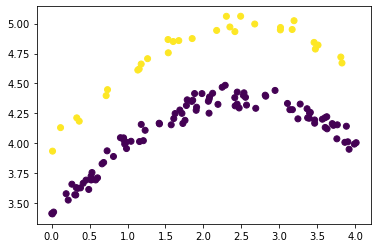

In [ ]:
plt.scatter(df.X, df.y, c=df.TaskID)

In [ ]:
dls_source = get_source_task(df)
dls_target = get_target_task(df)

In [ ]:
set_seed(10)
# set_random_states(10, 10,10, 10, 10, 10)
source_model = MultiLayerPerceptron([1, 100, 10, 5, 1], use_bn=True, bn_cont=False)
learn_source = Learner(dls_source, source_model, metrics=rmse)

In [ ]:
learn_source.fit(25, lr=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,13.244592,12.791247,3.576485,00:00
1,12.564035,10.874581,3.297663,00:00
2,11.748777,8.843756,2.973845,00:00
3,10.746590,6.983147,2.642564,00:00
4,9.563304,5.258692,2.293184,00:00
5,8.253172,2.996956,1.731172,00:00
6,6.909734,1.235961,1.111738,00:00
7,5.659206,0.326915,0.571765,00:00
8,4.602721,0.050623,0.224996,00:00
9,3.753726,0.031874,0.178534,00:00


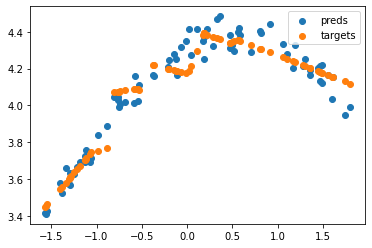

In [ ]:
targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(dls_source.train_ds.items.X, preds, label="preds")
plt.scatter(dls_source.train_ds.items.X, targets, label="targets")
plt.legend()
plt.show()

In [ ]:
# hide
# export
def _create_matrices(n_features, alpha):
    w_mean = torch.zeros(n_features)
    w_precision = torch.eye(n_features) / alpha
    
    return w_mean, w_precision
# minimal check if we can create the matricies
mean, precision = _create_matrices(10, 10)
test_eq(0, mean.sum())
test_eq(0.1, precision[0,0])

In [ ]:
# export
class LinearTransferModel(nn.Module):
    def __init__(self, source_model, num_layers_to_remove=1, 
                 name_layers_or_function_to_remove="layers", 
                 use_original_weights=True,
                 prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=False),
                include_original_features=False,
                use_pca=False):
        super().__init__()
        self.are_weights_initialized = False
        self.num_layers_to_remove = num_layers_to_remove
        self.ts_length = 1
        self.source_model = copy.deepcopy(source_model)
        self._prediction_model = prediction_model
        self.prediction_models = []
        if use_original_weights:
            self._prediction_model.empirical_bayes=False
        
        if callable(name_layers_or_function_to_remove):
            name_layers_or_function_to_remove(self.source_model, num_layers_to_remove)
        elif type(name_layers_or_function_to_remove) == str:
            layers = getattrs(self.source_model, name_layers_or_function_to_remove, default=None)[0]
            if layers is None:
                raise ValueError(f"Could not find layers by given name {name_layers_or_function_to_remove}.")
            elif isinstance(layers, torch.nn.modules.container.Sequential):
                setattr(self.source_model, name_layers_or_function_to_remove, layers[0:-self.num_layers_to_remove])
            else:
                raise ValueError(f"Only sequential layers are supported.")
        else:
            ValueError("Unknown type for name_layers_or_function_to_remove")
            
        if num_layers_to_remove != 1 and use_original_weights:
            raise ValueError("Can only reuse weights when using the last layers due to the dimension.")
        elif num_layers_to_remove == 1 and use_original_weights:
            
            for element in layers[-1]:
                if isinstance(element, nn.Linear):
                    # create mean matrix including bias
                    w_mean = copy.copy(element.weight.data)
                    bias = copy.copy(element.bias.data)
                    w_mean = w_mean.reshape(w_mean.shape[1])
                    w_mean = to_np(torch.cat([bias, w_mean]))
                    
                    # create precision and variance matrix
                    self.n_features = w_mean.shape[0]
                    
                    model = self._create_single_model(self.n_features)
                    model.w_mean = w_mean
                    self.prediction_models.append(model)
                    
                    self.are_weights_initialized = True
                    
            if not self.are_weights_initialized:
                raise ValueError(f"Could not find linear layer in last layer {self.layers[-1]}")
        
        
        freeze(self.source_model)
        self.include_original_features = include_original_features
        
        # fake param so that it can be used with pytorch trainers
        self.fake_param=nn.Parameter(torch.zeros((1,1), dtype=torch.float))
        self.fake_param.requires_grad =True
        self.use_pca = use_pca
        self.pca_model = None
        
    def _create_single_model(self,n_features):
        model = copy.copy(self._prediction_model)
        model._create_matrices(np.ones(n_features).reshape(1, n_features))
        model.w_covariance = np.linalg.inv(model.w_precision)
        return model
        
        
    @property
    def alpha(self):
        return self._prediction_model.alpha
    
    @property
    def beta(self):
        return self._prediction_model.beta
    
    @alpha.setter
    def alpha(self, alpha):
        self.prediction_model.alpha = alpha
        
    @beta.setter
    def beta(self, beta):
        self.prediction_model.beta = beta
        
    def transform(self, cats, conts):
        n_samples = conts.shape[0]
        
        x_transformed =  self.source_model(cats, conts)
        
        x_transformed = x_transformed.reshape(n_samples, -1)
        
        if self.include_original_features:
            x_transformed = torch.cat([ conts.reshape(n_samples,-1), x_transformed], axis=1)
        
        if self.use_pca and self.pca_model == None:
            self.pca_model = PCA(n_components=10)
            
        if self.training and self.use_pca:
            x_transformed = self.pca_model.fit_transform(x_transformed)
        elif self.use_pca:
            x_transformed = self.pca_model.transform(x_transformed)
        
        return torch.tensor(x_transformed)
    
    def forward(self, cats, conts):
        n_samples = conts.shape[0]
        self.ts_length = 1
        if len(conts.shape) == 3:
            self.ts_length = conts.shape[2]
        
        x_transformed = self.transform(cats, conts) 
        
        if not self.are_weights_initialized:
            self.n_features = x_transformed.shape[1]+1
            
            for idx in range(self.ts_length):
                model = self._create_single_model(self.n_features)
                self.prediction_models.append(model)
                    
            self.are_weights_initialized=True
        
        if self.training:
            return x_transformed
        else:
            preds = self.predict(cats, conts)
            
            return preds
            
    def update(self, X, y):
        X = to_np(X)
        y = to_np(y)
        
        for idx, prediction_model in enumerate(self.prediction_models):
            if len(y.shape) == 3:
                y_cur = y[:,:,idx]
            
            
            prediction_model.fit(X, y_cur.ravel())
            
        
        return self

    def predict(self, cats, conts):
        x_transformed = self.transform(cats, conts) 
        x_transformed = to_np(x_transformed)
        
        y_pred_means = np.zeros((len(x_transformed), len(self.prediction_models)))
        for idx, prediction_model in enumerate(self.prediction_models):
            y_pred_mean = prediction_model.predict(x_transformed)
            y_pred_means[:,idx] = y_pred_mean

        return torch.tensor(y_pred_means)

    def predict_proba(self, cats, conts):
        x_transformed = self.transform(cats, conts)
        x_transformed = to_np(x_transformed)
        
        y_pred_means = np.zeros((len(x_transformed), len(self.prediction_models)))
        y_pred_stds = np.zeros((len(x_transformed), len(self.prediction_models)))
        for idx, prediction_model in enumerate(self.prediction_models):
            y_pred_mean, y_pred_std = prediction_model.predict_proba(x_transformed)
            y_pred_means[:,idx] = y_pred_mean
            y_pred_stds[:,idx] = y_pred_std

        return torch.tensor(y_pred_means), torch.tensor(y_pred_stds),
    
    def pred_transformed_X(self, X_transformed):
        
        y_pred_means = np.zeros((len(x_transformed), len(self.prediction_models)))
        for idx, prediction_model in enumerate(self.prediction_models):
            y_pred_mean = prediction_model.predict(x_transformed)
            y_pred_means[:,idx] = y_pred_mean

        return torch.tensor(y_pred_means)
    
    def loss_func(self, x_transformed, ys):
        
        if self.training:
            self.update(x_transformed, ys)
        
            fake_loss = torch.tensor([0], dtype=torch.float)
            fake_loss.requires_grad=True
            return self.fake_param + fake_loss
        else:
            # in case of validation return MSE
            return ((x_transformed-ys)**2).mean()


In [ ]:
# hide
cats, conts, targets = dls_target.one_batch()
# test if we get the same results as with the original model
with torch.no_grad():
    
    preds_source = source_model(cats, conts)
    ltmodel = LinearTransferModel(source_model, num_layers_to_remove=1, use_original_weights=True)
    
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict_proba(cats, conts)[0]
    test_close(preds_source, preds_target)


In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
                                  )
target_model = target_model.eval()

Create forecats and check if the source model and the untrained model create the same results

In [ ]:
cats, conts, targets = dls_source.one_batch()

In [ ]:
with torch.no_grad():
    preds_source = source_model(cats, conts).ravel()
preds_target = target_model(cats.to("cpu"), conts.to("cpu"))

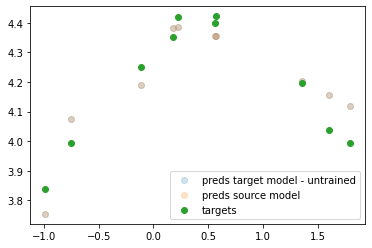

In [ ]:
# targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(conts, preds_target, label="preds target model - untrained", alpha=0.2)
plt.scatter(conts, preds_source.detach(), label="preds source model", alpha=0.2)
plt.scatter(conts, targets, label="targets")

plt.legend()
plt.show()

In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
#                                   alpha=(1/0.1)**2, beta=(1/0.1)**2)
                                   )
target_model.training = True

In [ ]:
preds_before_training = []
conts_test_before_training = []
targets_before_training = []
for cats, conts, targets in dls_target[0]:
    target_model(cats, conts)
    pred_before_training = target_model.predict(cats, conts)
    preds_before_training.append(pred_before_training)
    conts_test_before_training.append(conts)
    targets_before_training.append(targets)
    
preds_before_training = torch.cat(preds_before_training)
conts_test_before_training = torch.cat(conts_test_before_training)
targets_before_training = torch.cat(targets_before_training)

In [ ]:
pred_before_training.shape, targets_before_training.shape

(torch.Size([10, 1]), torch.Size([20, 1]))

In [ ]:
for cats, conts, targets in dls_target[0]:
    x_transformed = target_model.forward(cats, conts)
    target_model = target_model.update(x_transformed, targets.ravel())
    x_transformed = target_model.forward(cats, torch.tensor(dls_target.train_ds.items.X.values).reshape(-1,1))
    target_model = target_model.update(x_transformed, torch.tensor(dls_target.train_ds.items.y.values).ravel())

In [ ]:
preds_after_training = []
conts_test_after_training = []
targets_after_training = []
for cats, conts, targets in dls_target[0]:
    pred_after_training = target_model.predict(cats, conts)
    preds_after_training.append(pred_after_training)
    conts_test_after_training.append(conts)
    targets_after_training.append(targets)
    
preds_after_training = torch.cat(preds_after_training)
conts_test_after_training = torch.cat(conts_test_after_training)
targets_after_training = torch.cat(targets_after_training)

In [ ]:
((targets_after_training.reshape(-1)-preds_after_training.reshape(-1))**2).mean()**0.5

tensor(0.0577, dtype=torch.float64)

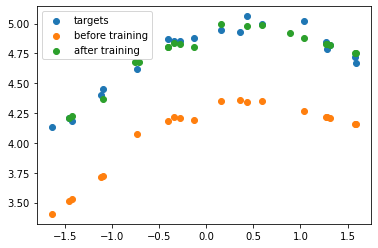

In [ ]:
plt.scatter(conts_test_before_training, targets_before_training, label="targets")
plt.scatter(conts_test_before_training, preds_before_training, label="before training")
plt.scatter(conts_test_after_training, preds_after_training, label="after training")
plt.legend()

Lets assure that it also works with pytorch trainings such as the fastai training loop

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   )

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   )


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.012760,0.112962,00:00


We can also not using the last layer as initializaition

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=False))


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.006348,0.079674,00:00


Due to the few data samples, the empircal bayes is not working well.

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=True))


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.037106,0.192630,00:00


Or remove multiple layers

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=2, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=False)
                                   )


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.064279,0.253533,00:00


# Test on real world data

In [ ]:

from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.tabular.learner import *

In [ ]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m',
       'SinWindDirection60m', 'CosWindDirection60m', 'WindSpeed58mMinus_t_1',
       'SinWindDirection58mMinus_t_1', 'CosWindDirection58mMinus_t_1',
       'WindSpeed60mMinus_t_1', 'SinWindDirection60mMinus_t_1',
       'CosWindDirection60mMinus_t_1', 'WindSpeed58mPlus_t_1',
       'SinWindDirection58mPlus_t_1', 'CosWindDirection58mPlus_t_1',
       'WindSpeed60mPlus_t_1', 'SinWindDirection60mPlus_t_1',
       'CosWindDirection60mPlus_t_1']
cat_names = ['TaskID', 'Month', 'Day', 'Hour']

dls_source = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[0:1], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

dls_target = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[2], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

In [ ]:
learn_source = renewable_learner(dls_source, metrics=rmse)
learn_source.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.027319,0.016018,0.126564,00:01
1,0.017219,0.018726,0.136843,00:02
2,0.013632,0.013227,0.115009,00:04
3,0.013984,0.017421,0.131990,00:04
4,0.012524,0.011915,0.109158,00:07
5,0.012753,0.011677,0.108059,00:03
6,0.012387,0.014566,0.120690,00:03
7,0.011504,0.012284,0.110834,00:02
8,0.010993,0.013308,0.115359,00:02
9,0.011021,0.013208,0.114925,00:02


In [ ]:
target_model = LinearTransferModel(learn_source.model, 1, 
                                   use_original_weights=True,
                                  prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=False))
target_learner = RenewableLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.067663,0.010293,0.101457,00:01


In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)

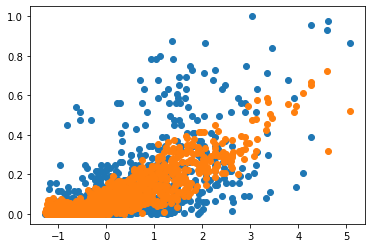

In [ ]:
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, targets)
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, preds)

## Test for timeseries

In [ ]:
from fastrenewables.timeseries.core import *
from fastrenewables.tabular.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [ ]:
def get_dls(y_names="PowerGeneration"):
#     if cont_names is None:
#         cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
#            'ASWDIRS_SFC_0_M', 'WindSpeed58m', "HourSin", "HourCos"]
    
    pd.options.mode.chained_assignment=None
    dls_source = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[0:1], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[#FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[2], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    return dls_source, dls_target



In [ ]:
dls_source, dls_target = get_dls()

In [ ]:
n_features = len(dls_source.train_ds.cont_names)

In [ ]:
learner = renewable_timeseries_learner(dls_source, metrics=rmse, layers=[n_features, 200, 100, 50, 25, 5, 1])

In [ ]:
learner.fit_one_cycle(12)

epoch,train_loss,valid_loss,_rmse,time
0,0.044892,0.024418,0.156262,00:02
1,0.026811,0.013380,0.115673,00:02
2,0.019984,0.012043,0.109739,00:03
3,0.016930,0.011672,0.108038,00:02
4,0.015357,0.011816,0.108700,00:01
5,0.014391,0.012016,0.109616,00:03
6,0.013670,0.012425,0.111468,00:02
7,0.013023,0.012481,0.111717,00:02
8,0.012484,0.012493,0.111773,00:02
9,0.012059,0.012199,0.110449,00:02


In [ ]:
cat_names

['TaskID', 'Month', 'Day', 'Hour']

In [ ]:
preds, targets = learner.predict(ds_idx=1, filter=True)

In [ ]:
dls_source.valid_ds.cont_names

(#23) ['T_HAG_2_M','RELHUM_HAG_2_M','PS_SFC_0_M','ASWDIFDS_SFC_0_M','ASWDIRS_SFC_0_M','WindSpeed58m','SinWindDirection58m','CosWindDirection58m','WindSpeed60m','SinWindDirection60m'...]

In [ ]:
id_ws = 5

We catch the the wind speed from the validation data to check the forecasts.

In [ ]:
windspeed = dls_source.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

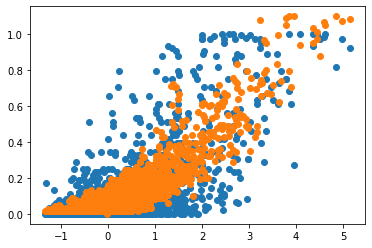

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)

In [ ]:
# export
def reduce_layers_tcn_model(tcn_model, num_layers=0):
    tcn_model.layers.temporal_blocks = tcn_model.layers.temporal_blocks[:-num_layers]

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(2, 2)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(23, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(23, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=Fal

The problem is that we have a lot of features while less samples compared to the linear model.

In [ ]:
5*24

120

In [ ]:
2*365

730

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(2, 2)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(23, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(23, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=Fal

In [ ]:
target_model = LinearTransferModel(learner.model, 1, 
                                   reduce_layers_tcn_model, 
                                   use_original_weights=False,
                                  include_original_features=False,
                                  prediction_model=BayesLinReg(10, 10, empirical_bayes=False),
                                  use_pca=False)

In [ ]:
target_learner = RenewableTimeseriesLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.011885,0.027373,0.113790,00:00


<ipython-input-292-77876d9e74b5>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transformed)


In [ ]:
target_learner.prediction_models[0:3]

[BayesLinReg(alpha=10, beta=10, empirical_bayes=False),
 BayesLinReg(alpha=10, beta=10, empirical_bayes=False),
 BayesLinReg(alpha=10, beta=10, empirical_bayes=False)]

In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)

<ipython-input-292-77876d9e74b5>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transformed)


In [ ]:
preds.shape, targets.shape

((1632,), (1632,))

In [ ]:
windspeed = dls_target.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

In [ ]:
windspeed.shape

torch.Size([1632, 1])

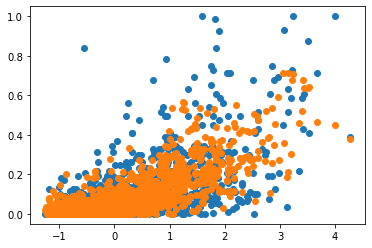

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)

In [ ]:
target_model = LinearTransferModel(learner.model, 1, 
                                   reduce_layers_tcn_model, 
                                   use_original_weights=False,
                                  include_original_features=False,
                                  prediction_model=BayesLinReg(0.1, 0.1, empirical_bayes=True),
                                  use_pca=True)

In [ ]:
cats, conts, targets = convert_to_tensor_ts(dls_target.train_ds)

In [ ]:
X_transformed = target_model(cats, conts)

In [ ]:
target_model = target_model.update(X_transformed, targets )

In [ ]:
target_model.prediction_models[0:]

[BayesLinReg(alpha=1596.1145440638443, beta=426.7999890652902),
 BayesLinReg(alpha=1498.8429881904901, beta=231.10304147266223),
 BayesLinReg(alpha=1810.4639697312593, beta=220.9876656343763),
 BayesLinReg(alpha=1576.4762414844074, beta=207.31362962731453),
 BayesLinReg(alpha=1506.0232112078338, beta=258.78776333795497),
 BayesLinReg(alpha=1328.6553660479344, beta=212.09282974461502),
 BayesLinReg(alpha=917.6368643195854, beta=175.00964015039762),
 BayesLinReg(alpha=909.0582031478964, beta=136.5941554894354),
 BayesLinReg(alpha=650.0671166746832, beta=122.31216973768794),
 BayesLinReg(alpha=538.5565588722459, beta=101.16323204967786),
 BayesLinReg(alpha=398.0885936770126, beta=73.93736189236765),
 BayesLinReg(alpha=321.96773731371127, beta=66.45588965260231),
 BayesLinReg(alpha=279.5194953579479, beta=65.70377083387673),
 BayesLinReg(alpha=271.73853315698926, beta=57.125522094677365),
 BayesLinReg(alpha=278.94428705718775, beta=48.04127834763031),
 BayesLinReg(alpha=343.05529814861336,

In [ ]:
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
target_model.eval()
yhats = target_model(cats, conts)

In [ ]:
((targets.ravel()-yhat.ravel())**2).mean()**0.5

tensor(0.1536, dtype=torch.float64)

In [ ]:
windspeed = dls_target.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

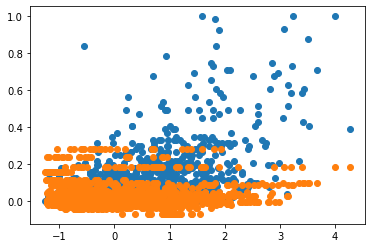

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, yhat)